<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/training-loop-v2/notebooks/TransGAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Tue Apr 20 18:10:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    51W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace

In [3]:
from google.colab import drive
drive.mount('/content/drive')
gdrive = Path('drive/MyDrive')
# gdrive = Path('/home/AP')

# Create a required checkpoint instance. 
# If does not exists, Checkpoint class will create one.
ckp_folder = gdrive/'full_v2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!git clone --single-branch --branch training-loop-v2 https://github.com/azfarkhoja305/GANs.git
!git -C GANs/ pull

fatal: destination path 'GANs' already exists and is not an empty directory.
Already up to date.


In [5]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [6]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [7]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
!PYTHONPATH=./GANs python ./GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats/cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Training

In [9]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 200
augments = "translation,cutout,color"

Files already downloaded and verified


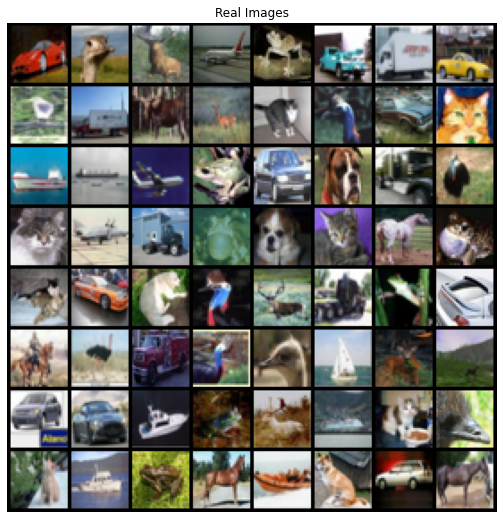

In [10]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
display_images(dataset.train_loader)

In [11]:
Gen = TGenerator(latent_dims=latent_dims, use_att_mask=True).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

## Generator Co-task

In [12]:
def reduce_resolution(image_batch):
    """ Function to reduce the resolution of an image by half. """
    return F.interpolate(image_batch, scale_factor=0.5, mode='bilinear',
                          align_corners=False, recompute_scale_factor=False)

In [13]:
mse_loss = nn.MSELoss(reduction='mean')
lamb = 50.0

## Continue Training Loop

In [14]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args,augments=augments).to(device)
# summary(Dis,(3,32,32,))

In [15]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [16]:
loss_logs = {'gen_loss': [], 'dis_loss': []}
img_list = []

In [17]:
ckp_class = Checkpoint(ckp_folder, max_epochs=num_epochs, num_ckps=40, start_after=0.025)

# check if any existing checkpoint exists, none found hence start_epoch is 0.
# Optimizer states also get saved
Gen, Dis, optG, optD, start_epoch, step, old_logs = \
                        ckp_class.check_if_exists(Gen, Dis, optG, optD)

loss_logs = old_logs or loss_logs
start_epoch #, loss_logs
print(step)

Checkpoint folder with checkpoints already exists. Searching for the latest.
=> Loading checkpoint: drive/MyDrive/full_v2/GanModel_005.pth
9372


In [18]:
# number of prints per epoch 
num = 4
print_at = np.linspace(100, len(dataset.train_loader)-1, num=num, dtype=np.int).tolist()

# Fixes

In [19]:
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

In [20]:
max_iter = 500000
n_critic = 5
gen_scheduler = LinearLrDecay(optG, lr, 0.0, 0, max_iter * n_critic)
dis_scheduler = LinearLrDecay(optD, lr, 0.0, 0, max_iter * n_critic)
g_lr = gen_scheduler.step(step)
d_lr = dis_scheduler.step(step)
assert g_lr == d_lr
print(g_lr)

9.962512e-05


In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.xavier_uniform_(m.weight.data, 1.)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

if start_epoch == 0:
    print('Initializing parameters...')
    Gen.apply(weights_init)
    Dis.apply(weights_init)

# Loop

In [ ]:
for epoch in tqdm(range(start_epoch, num_epochs)):
    for i, data in enumerate(tqdm(dataset.train_loader, leave=False)):
        
        ###########################
        # (1) Update Dis network
        ###########################
        
        ## Train with all-real batch
        Dis.zero_grad()
        real = data[0].to(device)
        output_real = Dis(real).view(-1)

        ## Train with all-fake batch
        dis_z = torch.randn(dis_batch_sz, latent_dims, device=device)
        fake_1 = Gen(dis_z, epoch).detach()
        output_fake_1 = Dis(fake_1).view(-1)

        ## Compute loss and backpropagate
        errD = wgangp_eps_loss(Dis, real, fake_1, 1.0, output_real, output_fake_1)
        errD.backward()
        torch.nn.utils.clip_grad_norm_(Dis.parameters(), 5.0)
        optD.step()

        ###########################
        # (2) Update Gen network
        ###########################
        if step % n_critic == 0:
            Gen.zero_grad()
            gen_z = torch.randn(gen_batch_sz, latent_dims, device=device)
            fake_2 = Gen(gen_z, epoch)
            output_fake_2 = Dis(fake_2).view(-1)
            errG = -torch.mean(output_fake_2)

            # Co-training task
            low_res_img = reduce_resolution(real)
            generated_img = Gen.super_resolution(low_res_img,epoch=epoch)
            co_train_loss = mse_loss(generated_img, real)

            errG += lamb * co_train_loss
            errG.backward()
            torch.nn.utils.clip_grad_norm_(Gen.parameters(), 5.0)
            optG.step()

            g_lr = gen_scheduler.step(step)
            d_lr = dis_scheduler.step(step)
            assert g_lr == d_lr
            
            # Save Losses for plotting later
            loss_logs['gen_loss'].append(errG.item())

        ###########################
        # (3) Output
        ###########################

        # Save Losses for plotting later
        loss_logs['dis_loss'].append(errD.item())

        step += 1

        if i in print_at:
            # Output training stats averged over last 100 iterations
            gen_mean = np.mean(loss_logs['gen_loss'][-100:])
            dis_mean = np.mean(loss_logs['dis_loss'][-100:])
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataset.train_loader)}]\t'
                  f'Loss_D: {round(gen_mean, 4)}\t',
                  f'Loss_G: {round(dis_mean, 4)}')
        
            # Check how the generator is doing by saving G's output on fixed_noise
            with torch.no_grad():
                fixed_fake = Gen(fixed_z, epoch).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake, padding=2, normalize=True))
    
    # Checkpoint
    ckp_class.at_epoch_end(Gen, Dis, optG, optD, epoch=epoch, step=step, loss_logs=loss_logs)

[6/200][100/1562]	Loss_D: 1.6427	 Loss_G: -0.028


# Analysis

In [ ]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0])
display_images(img_list, ax = axs[1])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_logs['gen_loss'],label="G")
plt.plot(loss_logs['dis_loss'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.ylim([-10,10])
plt.legend()
plt.show()

Calculating FID Score

In [ ]:
from metrics.torch_is_fid_score import is_fid_from_generator
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
inception_score, fid = is_fid_from_generator(generator=Gen,
                                        latent_dims=latent_dims,
                                        num_imgs=10000,
                                        batch_sz=256,
                                        fid_stat_path = stat_path)

In [ ]:
print(f"\nFID score: {fid}")
print(f"\nIS: {inception_score}")

In [ ]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani

In [ ]:
!kill $(ps aux | awk '{print $2}')